## Notebook Summary

- **multiclass classification** using a synthetic blob dataset
- prepare tabular data for PyTorch models
- Build a feedforward neural network for multiclass prediction
- Uses logits with `CrossEntropyLoss` for training
- Evaluates model performance using multiple classification metrics

**Core knowledge:**  
- How to design, train, and evaluate a multiclass classification neural network in PyTorch.


In [41]:
# importing
try:
    import torch
    import numpy
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    from torch import nn # nn-> all te building blocks for a neural network
    from sklearn.datasets import make_blobs # library to create blobs 
    from sklearn.model_selection import train_test_split
    print("Done Successfully")
except Exception as e:
    print("Failed to import",e)


Done Successfully


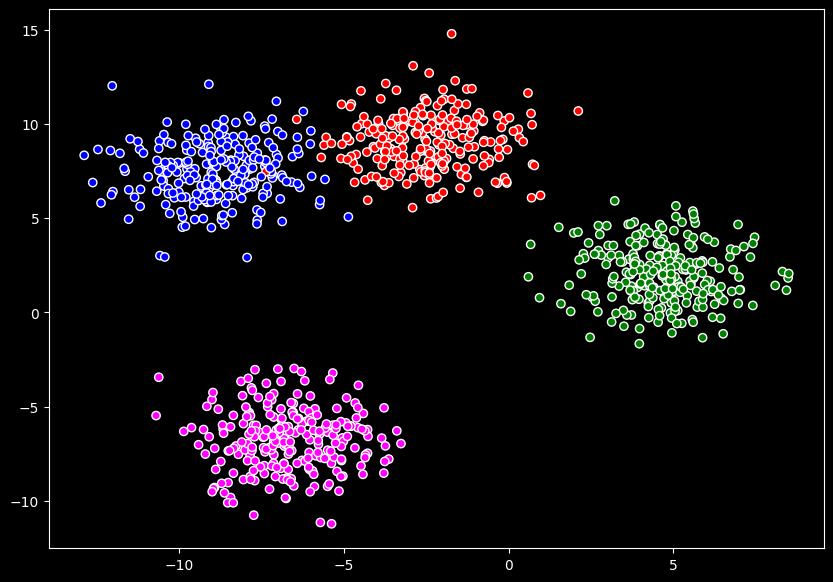

In [42]:
# set the hyperparameters
RANDOM_SEED=42
N_FEATURES=2
N_CLASSES=4

# 1. make blobs
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=N_FEATURES,
    centers=N_CLASSES,
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

# 2. turn data into tensors
X=torch.from_numpy(X_blob).type(torch.float)
y=torch.from_numpy(y_blob).type(torch.float)


# 3. split into training and testing
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)

# 4. visualise your data
plt.style.use("dark_background")
colors = ["red", "green", "magenta", "blue"]
cmap = ListedColormap(colors)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1],c=y_blob,cmap=cmap,edgecolor="white");


In [43]:
#device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
# multiclass classification model

class Blob_Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# create an intance of the class and send it to the device 
blobmodel=Blob_Model(input_features=2,output_features=4).to(device)
blobmodel

Blob_Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [45]:
# loss function , optimizer and accuracy function 
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=blobmodel.parameters(),
                           lr=0.01)

def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true) * 100

In [46]:
# make some test predictions 
blobmodel.eval()
with torch.inference_mode():
    y_logits=blobmodel(X_train.to(device))
y_logits[:10],y[:10] # one is from (0,1,2,3) while other is logits - or the unknown 



(tensor([[0.4162, 0.2781, 0.3768, 0.4024],
         [1.9053, 0.2419, 1.0641, 1.0184],
         [1.4858, 0.5568, 2.3230, 0.4460],
         [1.0980, 0.4855, 1.5615, 0.3261],
         [1.4868, 0.1804, 0.9199, 0.8184],
         [1.5532, 0.3845, 0.9384, 1.0344],
         [1.9893, 0.1337, 1.1729, 1.0368],
         [0.3815, 0.2829, 0.3337, 0.3484],
         [1.9501, 0.3803, 1.4637, 0.5970],
         [1.7045, 0.1373, 1.0282, 0.9429]]),
 tensor([3., 2., 2., 1., 1., 2., 1., 2., 2., 1.]))

In [47]:
# use softmax for converting logits into probabilities 
y_preds=torch.softmax(y_logits,dim=1) # softmax is completely skipped cuz it is numerically worse
y_preds

tensor([[0.2619, 0.2281, 0.2517, 0.2583],
        [0.4920, 0.0932, 0.2121, 0.2027],
        [0.2464, 0.0973, 0.5692, 0.0871],
        ...,
        [0.4909, 0.0933, 0.2109, 0.2048],
        [0.2606, 0.1255, 0.5033, 0.1106],
        [0.4935, 0.0904, 0.3119, 0.1041]])

In [48]:
# convert the probabilities into classes:
y_pred_labels=torch.argmax(y_preds,dim=1)
y_pred_labels[:5] # used softmax just for confidence building

tensor([0, 0, 2, 2, 0])

In [49]:
# send the data to the device
X_train, X_test= X_train.to(device), X_test.to(device)
y_train, y_test= y_train.type(torch.long).to(device), y_test.type(torch.long).to(device)


# training loop 
epochs=30

for epoch in range(epochs):
    blobmodel.train()

    y_logits=blobmodel(X_train)
    y_pred=torch.argmax(y_logits, dim=1)

    loss=loss_fn(y_logits, y_train)
    acc=accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    # testing
    blobmodel.eval()
    with torch.inference_mode():
        y_test_logits=blobmodel(X_test)
        y_test_preds=torch.argmax(y_test_logits,dim=1)

        test_loss=loss_fn(y_test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=y_test_preds)

        if epoch%4==0:
            print(f'Epoch: {epoch} | Training Loss: {loss:.4F} | Training Accuracy: {acc:.2F}% | Testing Loss: {test_loss:.4F} | Testing Accuracy: {test_acc:.2F}%')

Epoch: 0 | Training Loss: 1.2698 | Training Accuracy: 61.25% | Testing Loss: 1.1355 | Testing Accuracy: 62.00%
Epoch: 4 | Training Loss: 0.8166 | Training Accuracy: 94.75% | Testing Loss: 0.7113 | Testing Accuracy: 97.00%
Epoch: 8 | Training Loss: 0.5925 | Training Accuracy: 95.50% | Testing Loss: 0.5021 | Testing Accuracy: 96.50%
Epoch: 12 | Training Loss: 0.4421 | Training Accuracy: 92.62% | Testing Loss: 0.3699 | Testing Accuracy: 91.00%
Epoch: 16 | Training Loss: 0.3384 | Training Accuracy: 92.38% | Testing Loss: 0.2704 | Testing Accuracy: 93.50%
Epoch: 20 | Training Loss: 0.2584 | Training Accuracy: 97.38% | Testing Loss: 0.1968 | Testing Accuracy: 99.00%
Epoch: 24 | Training Loss: 0.1859 | Training Accuracy: 99.12% | Testing Loss: 0.1374 | Testing Accuracy: 99.00%
Epoch: 28 | Training Loss: 0.1239 | Training Accuracy: 98.88% | Testing Loss: 0.0910 | Testing Accuracy: 99.50%


Requirement alread satisfied


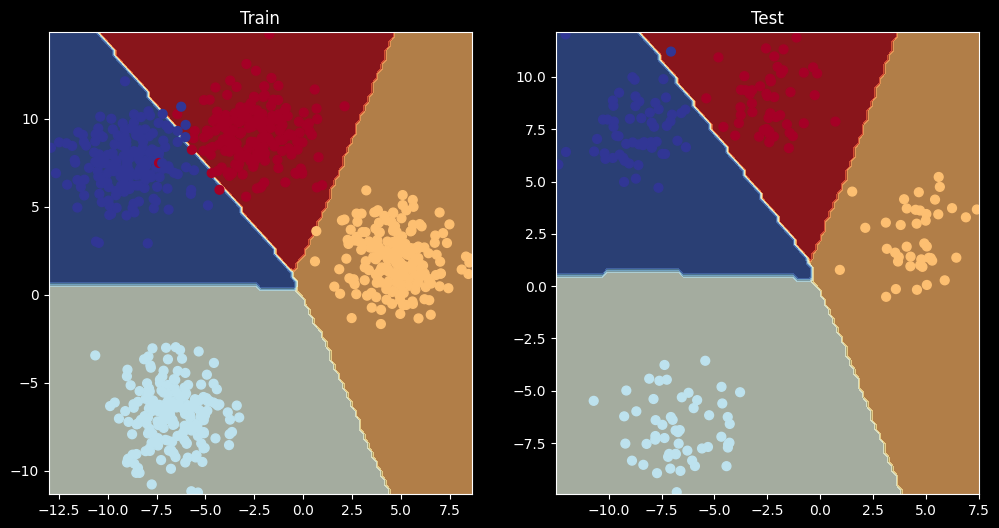

In [50]:
# plot decision boundary
# plot decision boundary
import requests
from pathlib import Path

# download helper function from pytorch repo if not already downloaded
if Path("helper_functions.py").is_file():
    print("Requirement alread satisfied")
else: 
    print("Downloading helper_functions.py")
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")

    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blobmodel, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blobmodel, X_test, y_test)

## More classification metrics 
---
| Metric | What it tells you | Why it matters |
|------|------------------|----------------|
| Accuracy | Overall correctness of predictions | Good first check, but can hide class imbalance |
| Precision | How many predicted positives are actually correct | Important when **false positives are costly** |
| Recall | How many actual positives the model correctly finds | Important when **false negatives are costly** |
| F1-score | Balance between precision and recall | Useful when classes are imbalanced |
| Confusion Matrix | Breakdown of TP, FP, FN, TN per class | Shows *where* the model is making mistakes |
| Classification Report | Precision, recall, F1, support together | Quick full performance summary |
